In [43]:
import pandas as pd
import networkx as nx
import ast
import numpy as np
import seaborn as sns
from matplotlib.pylab import plt
import itertools
import community
%matplotlib inline

データ読み込み、準備

In [19]:
#a = pd.read_csv("./the-movies-dataset/credits.csv")
credits = pd.read_csv("./the-movies-dataset/credits.csv")

In [20]:
## データフレーム中のstringをキャスト(dict型)のリストに変換する
def make_list_from_str(string):
    if isinstance(string, str):
        result_list = eval(string)
    else:
        result_list = np.nan
    return result_list

In [21]:
credits.cast = credits.cast.map(make_list_from_str)
credits.crew = credits.crew.map(make_list_from_str)

In [30]:
movies_cast_list = credits["cast"].tolist()

In [31]:
castkyoukilist = []
for movie in movies_cast_list:
    castlist = []
    for cast in movie:
        castlist.append(cast['cast_id'])
    castkyoukilist.append(castlist)

In [37]:
castkyoukilist[10:13]

[[1, 2, 3, 4, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
 [9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20],
 [1, 2, 8, 9, 10, 19, 20, 21, 22, 23, 24, 11, 25]]

ネットワーク化する

In [40]:
G = nx.Graph()
for castlist in castkyoukilist:
    G.add_nodes_from(castlist)
    G.add_edges_from(list(itertools.combinations(castlist, 2)))

In [47]:
def clusteringplot(G,partition):                                                                                                           
    size = float(len(set(partition.values())))                                                                                                 
    pos = nx.spring_layout(G)                                                                                                                  
    count = 0.                                                                                                                                 
    for com in set(partition.values()):                                                                                                        
        count += 1.                                                                                                                              
        list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]                                                            
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size=30, node_color = str(count/size))                                                                                                                                 
    plt.show()

In [52]:
def dividecluster(partition):
    valuelist = list(set(partition.values()))
    num = len(valuelist)
    arr = [[] for i in range(num)]
    for k,v in partition.items():
        arr[v].append(k)
    return arr

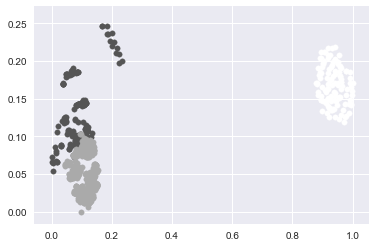

In [50]:
partition = community.best_partition(G)
clusteringplot(G,partition)

#ノードに名前つけるのと、共演回数でエッジの重みを変えるのがまだ

In [57]:
arr = dividecluster(partition)
with open('clustering.txt','w') as f:
    for cluster in arr:
        print(arr.index(cluster))
        print(cluster)

0
[14, 15, 16, 17, 18, 19, 20, 22, 24, 27, 8, 10, 11, 13, 31, 12, 28, 29, 30, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 6, 9, 21, 38, 46, 43, 48, 45, 314, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 337, 338, 339, 340, 341, 342, 343, 345, 351, 346, 349, 353, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 404, 402, 403, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 357, 367, 365, 368, 383, 829, 796, 835, 836, 837, 838, 795, 797, 834, 833, 798, 826, 825, 822, 376, 377, 378, 380, 354, 344, 375, 374, 373, 372, 371, 359, 360, 364, 361, 363, 369, 366, 362, 358, 370, 379, 440, 381, 382, 384, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438]
1
[26, 23, 25, 1, 2, 50, 3, 4, 5, 47, 44, 54, 55, 51, 56, 52, 53, 59, 60, 96, 97, 99, 100, 101, 102, 104, 109, 110, 112, 116, 115, 123, 49, 57, 58, 94, 95, 98, 103, 105, 106, 107, 111, 113, 114, 118, 119, 120, 121, 12

Cytoscapeか何かで可視化する用

networkxのHPに大体のできることが書いてある
https://networkx.github.io/documentation/networkx-1.9/reference/functions.html

In [60]:
labels = dict([(i, str(i)) for i in range(nx.number_of_nodes(G))])
nx.set_node_attributes(G, 'label', labels)
nx.set_node_attributes(G, 'community', partition)
nx.write_gml(G, "community.gml")

KeyError: 439